### setup

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time
import yaml

from myyololib.dataset import get_dataloader, preprocess_dataset
from myyololib.models import MyYOLOv8n, QYOLOv8n, NYOLOv8n

from myyololib.train_config import TrainConfig, FinetuneConfig
# from myyololib.trainer import train
# from myyololib.evaluator import evaluate
from myyololib.load_model import load_model, load_QAT_model, load_NPU_model
from myyololib.visualize import visualize_multiple_tensors, visualize_float_tensor_distribution, \
    visualize_tensor_distribution, visualize_multiple_poz, ActivationStatsCollector
from myyololib.npu_blocks import NConv2d
from myyololib.demo import demo


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model

In [8]:
train_loader, val_loader, coco_id2label, label2coco_category = get_dataloader()

loading annotations into memory...
Done (t=48.85s)
creating index...
index created!
loading annotations into memory...
Done (t=0.95s)
creating index...
index created!


In [15]:
# model = load_model('checkpoints/yolov8n.pt', device)

In [4]:
model = load_model('checkpoints/yolov8n.pt', device)

Start matching keys...

Matching keys done.



In [3]:
model = load_model('checkpoints/relu_091214.pth', device)

Loaded .pth state_dict
Start matching keys...

Matching keys done.



In [ ]:
# load QAT model with quantization config
with open('./config/quantization_config.yaml') as f:
    loaded_cfg = yaml.safe_load(f)

Qmodel = load_model('checkpoints/qat_091501.pth', device, model_type="qat", model_qcfg=loaded_cfg)

Start matching keys...

Matching keys done.



# Train

In [ ]:
Qmodel = load_QAT_model('checkpoints/relu_091214.pth', device, model_qcfg=loaded_cfg)
# QAT model fine-tuning
train(Qmodel, train_loader, val_loader, device, FinetuneConfig)

# Visualize

## Weight

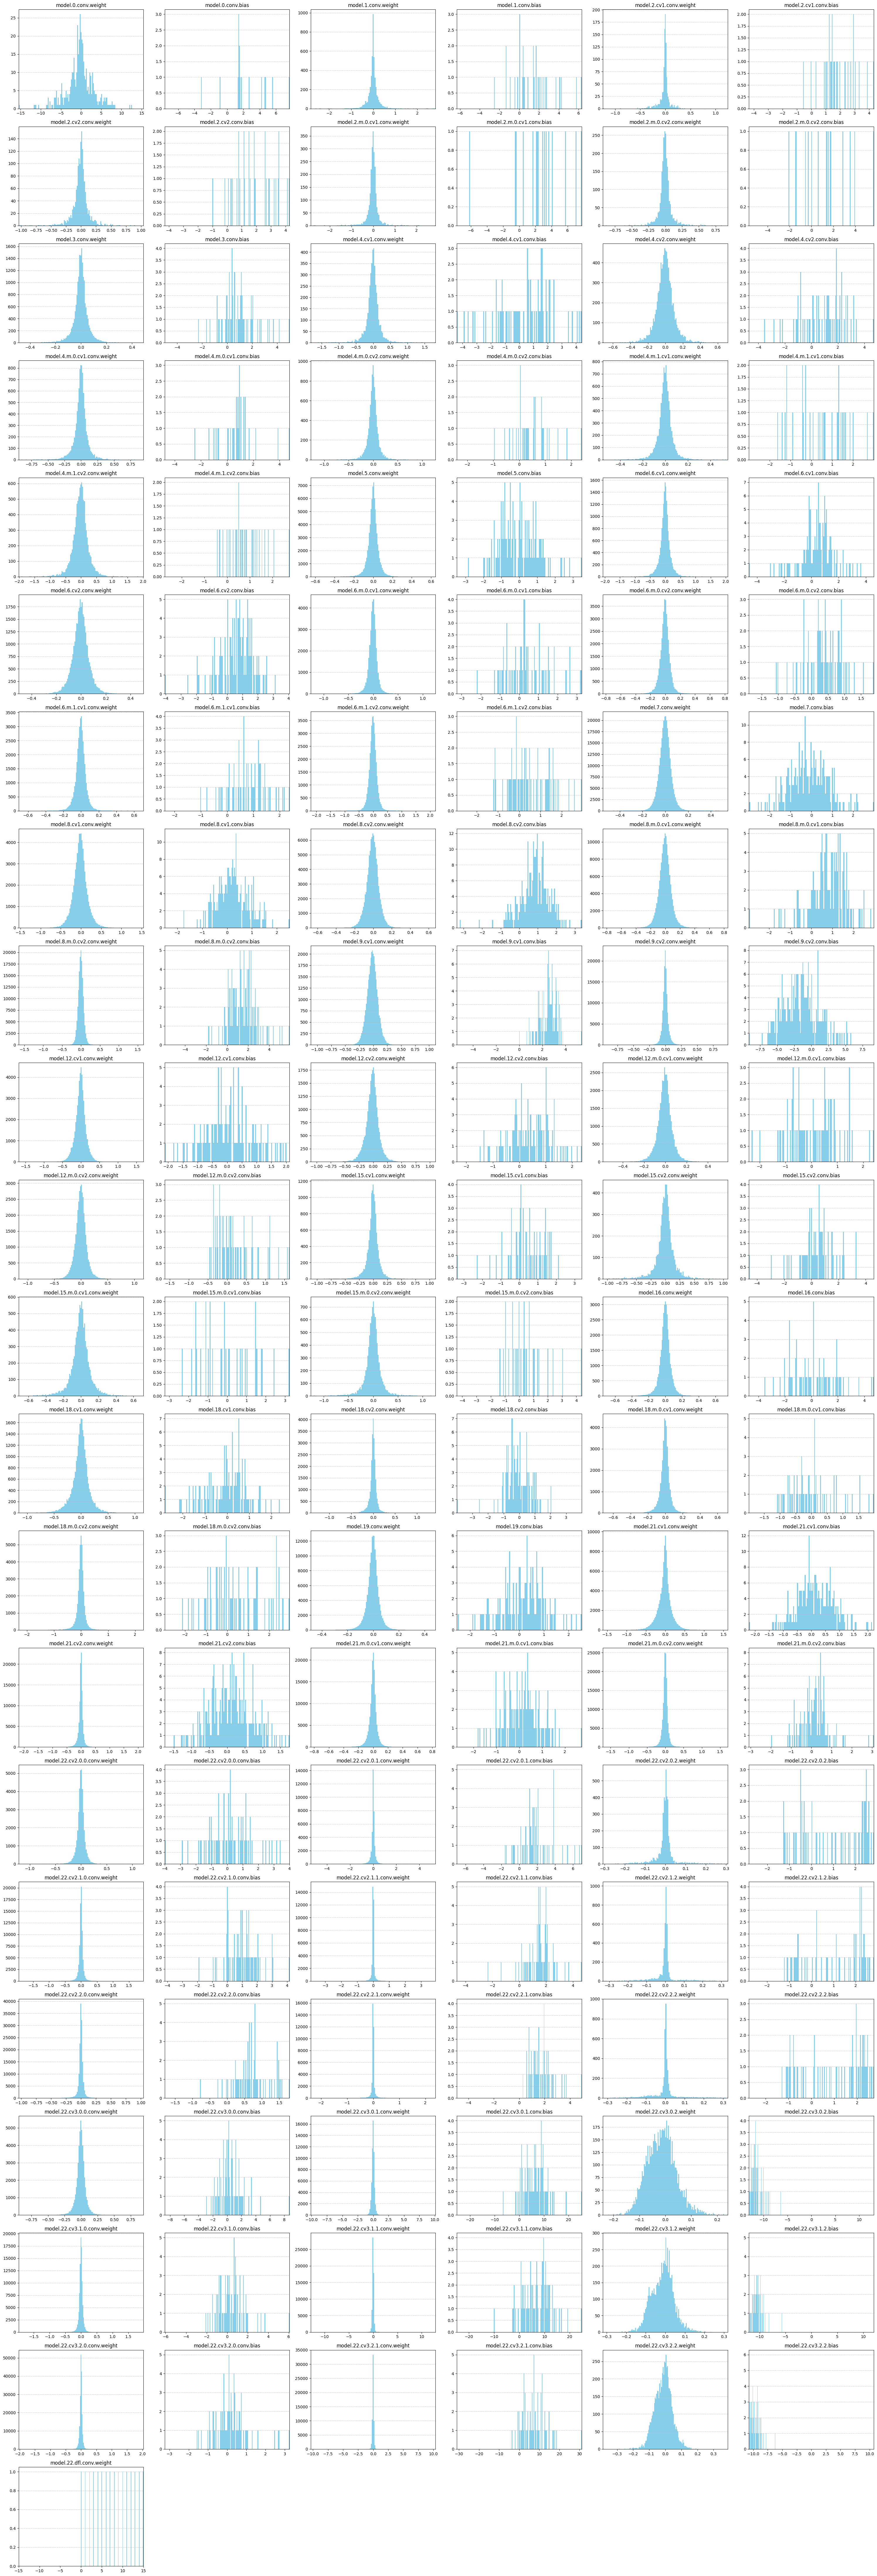

In [11]:
visualize_multiple_tensors(Qmodel.state_dict(), bins=128, n_cols=6)

## Activation

In [5]:
Nmodel = load_NPU_model('qat_091501.pth', device)

Start matching keys...

Matching keys done.



In [ ]:
asc = ActivationStatsCollector(Nmodel, NConv2d)

In [ ]:
# load trained NPU test_model and register hooks
run_batch = 1
for _ in range(run_batch): # run multiple iterations to collect activation statistics
    with torch.no_grad():
        images, annotations = next(iter(train_loader))
        inputs, batch = preprocess_dataset(images, annotations, coco_id2label, device) # preprocess dataset
        outputs = Nmodel(inputs, inference=True)
activation_stats = asc.get_stats()


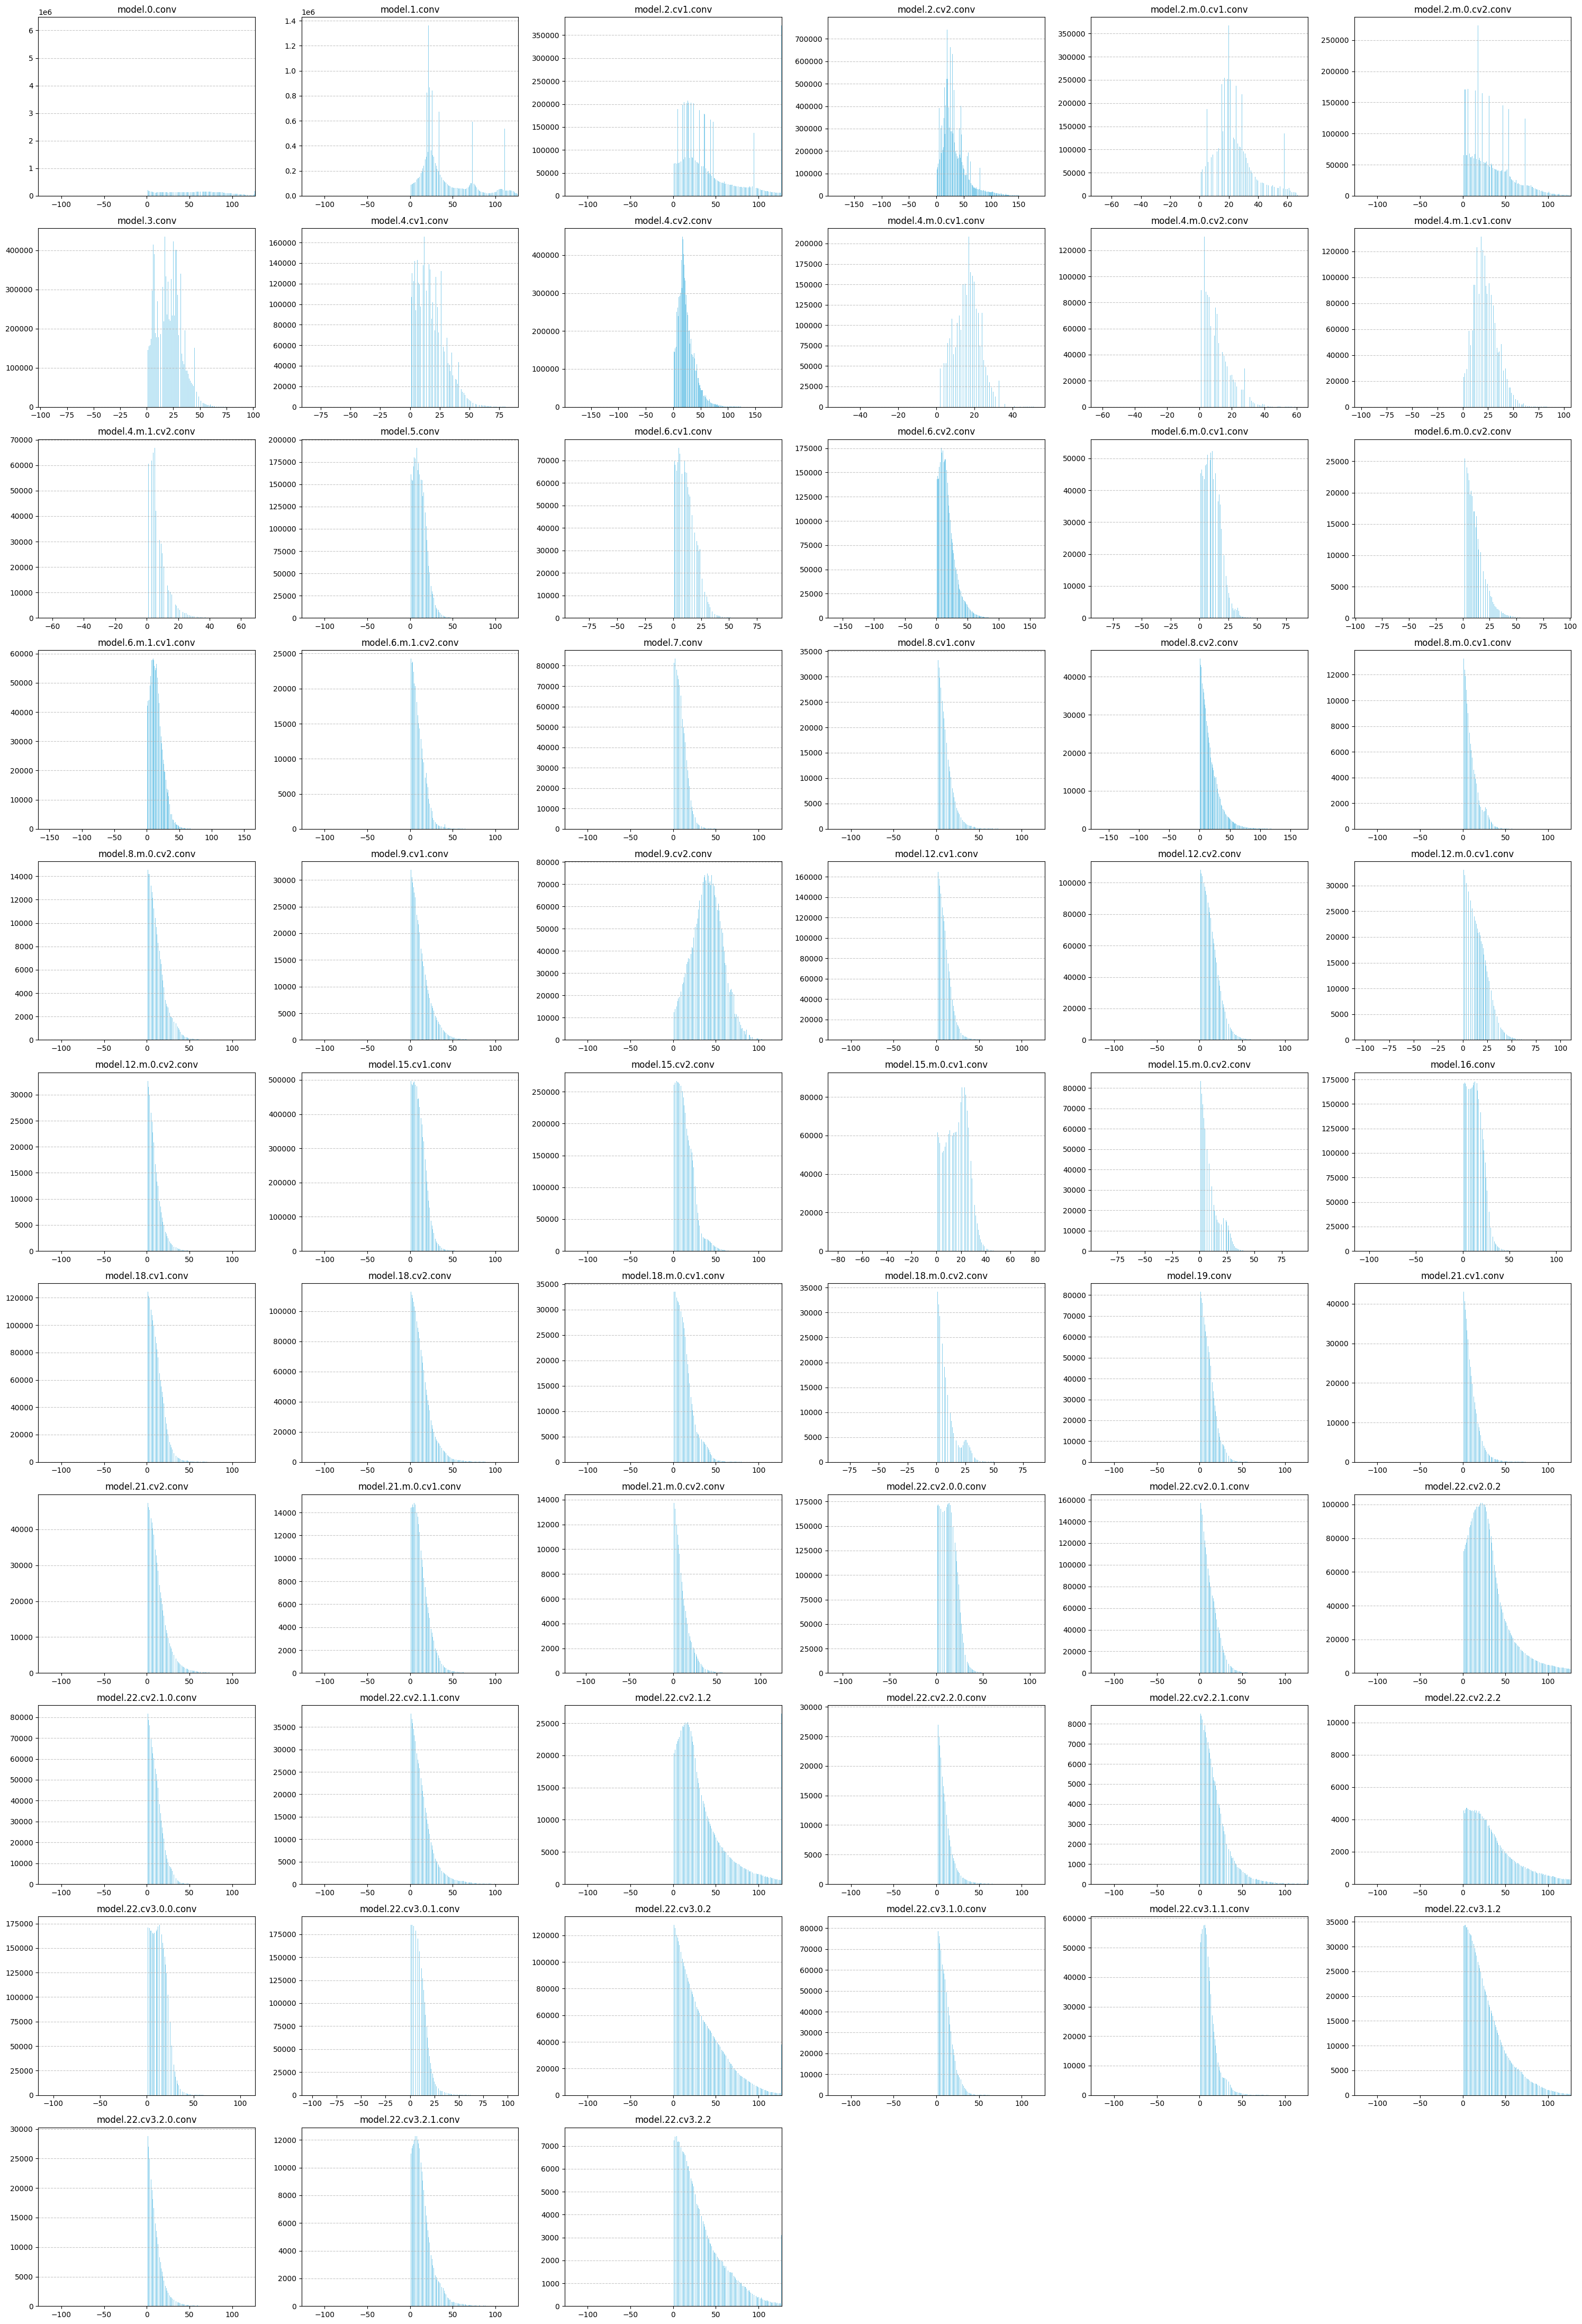

In [22]:
act_stats = {}
for layer_name, acts in activation_stats.items():
    acts = torch.cat(acts, dim=0)  # concatenate all batches
    temp = acts.permute(1, 0, 2, 3).contiguous()
    zero_mask = acts != 0 
    act_stats[layer_name] = acts[zero_mask] if zero_mask.sum() > 0 else torch.tensor(0.0)

visualize_multiple_tensors(act_stats, bins=256, n_cols=6) # zero values are excluded

# Demo

In [6]:
demo(train_loader, Nmodel, device, coco_id2label, label2coco_category, iou_threshold=0.3)

In [15]:
demo(train_loader, Qmodel, device, coco_id2label, label2coco_category, iou_threshold=0.7)

# Quantization Config Generator

In [ ]:
def bottleneck_qcfg_gen(cfg):
    return {
        "cv1": cfg.pop(0),
        "cv2": cfg.pop(0),
    }

def c2f_qcfg_gen(cfg, n):
    ret = {
        "cv1": cfg.pop(0),
        "cv2": cfg.pop(0),
    }
    for i in range(n):
        ret[f"m.{i}"] = bottleneck_qcfg_gen(cfg)
    return ret

def sppf_qcfg_gen(cfg):
    return {
        "cv1": cfg.pop(0),
        "cv2": cfg.pop(0),
    }

def detect_qcfg_gen(cfg):
    return {
        "cv2.0": cfg.pop(0),
        "cv2.1": cfg.pop(0),
        "cv2.2": cfg.pop(0),

        "cv3.0": cfg.pop(0),
        "cv3.1": cfg.pop(0),
        "cv3.2": cfg.pop(0),
    }

# note: config format: [num_bits, w_fraction_bits, a_fraction_bits]
quantization_config = {
    "layer_0": [8,3,7],
    "layer_1": [8,6,4],
    "layer_2": c2f_qcfg_gen([[8,6,4], # cv1
                             [8,6,4], # cv2
                             [8,6,4], # bottleneck 0.cv1
                             [8,6,4], # bottleneck 0.cv2
                             ], 1),
    "layer_3": [8,6,4],
    "layer_4": c2f_qcfg_gen([[8,6,4], # cv1
                             [8,6,4], # cv2
                             [8,6,4], # bottleneck 0.cv1
                             [8,6,4], # bottleneck 0.cv2
                             [8,6,4], # bottleneck 1.cv1
                             [8,6,4], # bottleneck 1.cv2
                             ], 2),
    "layer_5": [8,6,4],
    "layer_6": c2f_qcfg_gen([[8,6,4], # cv1
                             [8,6,4], # cv2
                             [8,6,4], # bottleneck 0.cv1
                             [8,6,4], # bottleneck 0.cv2
                             [8,6,4], # bottleneck 1.cv1
                             [8,6,4], # bottleneck 1.cv2
                             ], 2),
    "layer_7": [8,6,4],
    "layer_8": c2f_qcfg_gen([[8,6,4], # cv1
                             [8,6,4], # cv2
                             [8,6,4], # bottleneck 0.cv1
                             [8,6,4], # bottleneck 0.cv2
                             ], 1),
    "layer_9": sppf_qcfg_gen([[8,6,4], # cv1
                              [8,6,4], # cv2
                              ]),
    "layer_12": c2f_qcfg_gen([[8,6,4], # cv1
                              [8,6,4], # cv2
                              [8,6,4], # bottleneck 0.cv1
                              [8,6,4], # bottleneck 0.cv2
                              ], 1),
    "layer_15": c2f_qcfg_gen([[8,6,4], # cv1
                              [8,6,4], # cv2
                              [8,6,4], # bottleneck 0.cv1
                              [8,6,4], # bottleneck 0.cv2
                              ], 1),
    "layer_16": [8,6,4],
    "layer_18": c2f_qcfg_gen([[8,6,4], # cv1
                              [8,6,4], # cv2
                              [8,6,4], # bottleneck 0.cv1
                              [8,6,4], # bottleneck 0.cv2
                              ], 1),
    "layer_19": [8,6,4],
    "layer_21": c2f_qcfg_gen([[8,6,4], # cv1
                              [8,6,4], # cv2
                              [8,6,4], # bottleneck 0.cv1
                              [8,6,4], # bottleneck 0.cv2
                              ], 1),

    "layer_22": detect_qcfg_gen([[8,6,4], # cv2.0
                                 [8,6,4], # cv2.1
                                 [8,7,4], # cv2.2
                                 [8,6,4], # cv3.0
                                 [8,6,4], # cv3.1
                                 [8,7,3], # cv3.2
                                 ]),
}

import yaml


# YAML save 
class MyDumper(yaml.SafeDumper):
    pass

def represent_list_flow(dumper, data):
    return dumper.represent_sequence('tag:yaml.org,2002:seq', data, flow_style=True)

MyDumper.add_representer(list, represent_list_flow)

# save
with open('./config/quantization_config.yaml', 'w') as f:
    yaml.dump(quantization_config, f, Dumper=MyDumper, sort_keys=False)

# load
with open('./config/quantization_config.yaml') as f:
    loaded_cfg = yaml.safe_load(f)

# check
print(loaded_cfg)

